In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
import ltspice
import subprocess
import pickle

In [2]:
# loading parameters
# Read the variables from the file
with open("spice_models\\parameters.pkl", "rb") as file:
    data = pickle.load(file)

# Access variables from the dictionary
n = data["n"]
m = data["m"]
I = data["I"]
RF_finger = data["RF_finger"]
RB_finger = data["RB_finger"]
RF_busbar = data["RF_busbar"]
RB_busbar = data["RB_busbar"]
Rshunt = data["Rshunt"]
Rseries = data["Rseries"]
Rpogo = data["RPogo_pin"]
Probe_pos = data["Probe_pos"]
Probe_neg = data["Probe_neg"]

In [3]:
#make a log file for this simulation set (change this file name for each directory)
folder_name = "sim1"
file_path = "spice_models\\sim1\\"
net_name = "solar_cell"

creating the top, finite elements and bottom grid

In [4]:
def netlist_solar_cell_fin_ele(Rsh, Rsr, I, indx, indy):
    netlist =f"""
I{indx}_{indy} T{indx}_{indy} N{indx}_{indy} {I}
D{indx}_{indy} N{indx}_{indy} T{indx}_{indy} D
Rshunt{indx}_{indy} N{indx}_{indy} T{indx}_{indy} {Rsh}
Rseries{indx}_{indy} B{indx+1}_{indy+1} N{indx}_{indy} {Rsr}
"""
    return netlist

def netlist_solar_cell_top_ele(R_fingers, R_bb, n, m):
    netlist = ""
    # Rows - Fingers
    for j in range(0, m+1):  # Loop through rows of fingers
        for i in range(0, n):  # Loop through columns of fingers
            line = f"RF_f{i}_{j} T{i}_{j} T{i+1}_{j} {R_fingers[j][i]}\n"
            netlist += line  # Add to the netlist
    
    # Rows - Busbars
    for i in range(0, n+1):  # Loop through columns of busbars
        for j in range(0, m):  # Loop through rows of busbars
            line = f"RF_b{i}_{j} T{i}_{j} T{i}_{j+1} {R_bb[i][j]}\n"
            netlist += line  # Add to the netlist
            
    return netlist

def netlist_solar_cell_bottom_ele(R_fingers, R_bb, n, m):
    netlist = ""
    # Rows - Fingers
    for j in range(0, m):  # Loop through rows of fingers
        for i in range(0, n):  # Loop through columns of fingers
            line = f"RB_f{i}_{j} B{i}_{j} B{i+1}_{j} {R_fingers[j][i]}\n"
            netlist += line  # Add to the netlist
    
    # Rows - Busbars
    for i in range(0, n):  # Loop through columns of busbars
        for j in range(0, m):  # Loop through rows of busbars
            line = f"RB_b{i}_{j} B{i}_{j} B{i}_{j+1} {R_bb[i][j]}\n"
            netlist += line  # Add to the netlist
    
    return netlist

def netlist_V_source():
    netlist = f"V1 Vpos 0 DC 0\n"
    return netlist

def netlist_simtype():
    netlist = ".dc V1 0 0.8 0.01\n"
    return netlist

In [5]:
# Probe_pos = [(0,50)]
# Probe_neg = [(2,25)]

In [6]:
def solar_cell_netlist():

    # Initialize the netlist with the header
    netlist = """* C:\\Drive\\semester 7\\BTP-1\\work4_EL\\finite_element_model\\"""
    netlist += file_path
    netlist += net_name + '.asc\n'    
    
    # top resistance grid
    # nodes from T00 to Tnn
    netlist += netlist_solar_cell_top_ele(RF_finger, RF_busbar, n, m)

    # finite element
    for i in range(0,n):
        for j in range(0,m):    
            netlist += netlist_solar_cell_fin_ele(Rshunt[i][j], Rseries[i][j], I, i, j)
    
    # bottom resistance grid
    # nodes from B00 to Bnn
    netlist += netlist_solar_cell_bottom_ele(RB_finger, RB_busbar, n, m)

    # adding the voltage source
    netlist += netlist_V_source()

    for (x,y) in Probe_pos:
        # netlist = netlist.replace(f" B{x}_{y}", " Vpos")
        netlist += f"RpogoB{x}_{y} B{x}_{y} Vpos {Rpogo}\n"
    
    for (x,y) in Probe_neg:
        # netlist = netlist.replace(f" T{x}_{y}", " 0")
         netlist += f"RpogoT{x}_{y} T{x}_{y} 0 {Rpogo}\n"

    # adding the simulation type
    netlist += netlist_simtype()

    # Add the footer
    netlist += """.model D D
.lib C:\\Users\\manik\\AppData\\Local\\LTspice\\lib\\cmp\\standard.dio
.backanno
.end"""

    return netlist


output_file = file_path + net_name +'.net'
with open(output_file, 'w') as file:
    file.write(solar_cell_netlist())

now i have the netlist ready lets try simulating it!

In [7]:
# Path to LTSpice executable
ltspice_exe = 'C:\\Users\\manik\\AppData\\Local\\Programs\\ADI\\LTspice\\LTspice.exe'

def RunLTsimulation(netlist_file):
    # Run LTSpice simulation
    subprocess.run([ltspice_exe, '-b', netlist_file], check=True)

# Path to the netlist file
netlist_file = output_file 

#running simulation
RunLTsimulation(netlist_file)

# Extract data
# Load the LTSpice data
lt = ltspice.Ltspice(file_path + net_name +'.raw')
lt.parse()

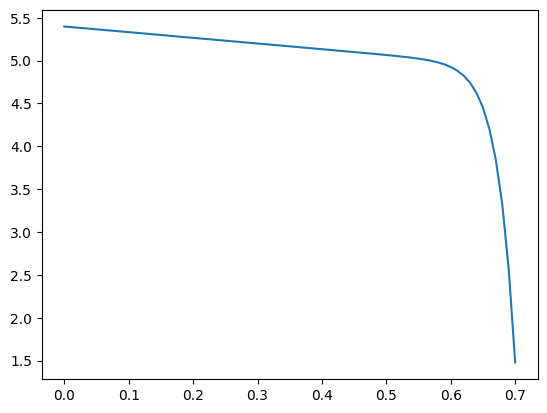

In [8]:
I = lt.get_data("I(V1)")
V = lt.get_data("v1")
#find the point where I becomes zero and stop ploting there
zero_crossing_index = np.argmax(I <= 0)  # First index where I <= 0

# Slice the data up to the zero-crossing point
V_trimmed = V[:zero_crossing_index]
I_trimmed = I[:zero_crossing_index]

plt.plot(V_trimmed,I_trimmed)


In [9]:
# Voltage distribution on each finite element
VB_grid = []
VF_grid = []
I_grid = []

for i in range(0, n):
    for j in range(0, m):
        VF_grid.append(lt.get_data(f"V(t{i}_{j})"))
        VB_grid.append(lt.get_data(f"V(b{i}_{j})"))
        I_grid.append(lt.get_data(f"I(Rseries{i}_{j})"))

sz = len(I_grid[0])
I_grid = np.array(I_grid).reshape(n, m, sz)
VF_grid = np.array(VF_grid).reshape(n, m, sz)
VB_grid = np.array(VB_grid).reshape(n, m, sz)


(6, 100, 81)


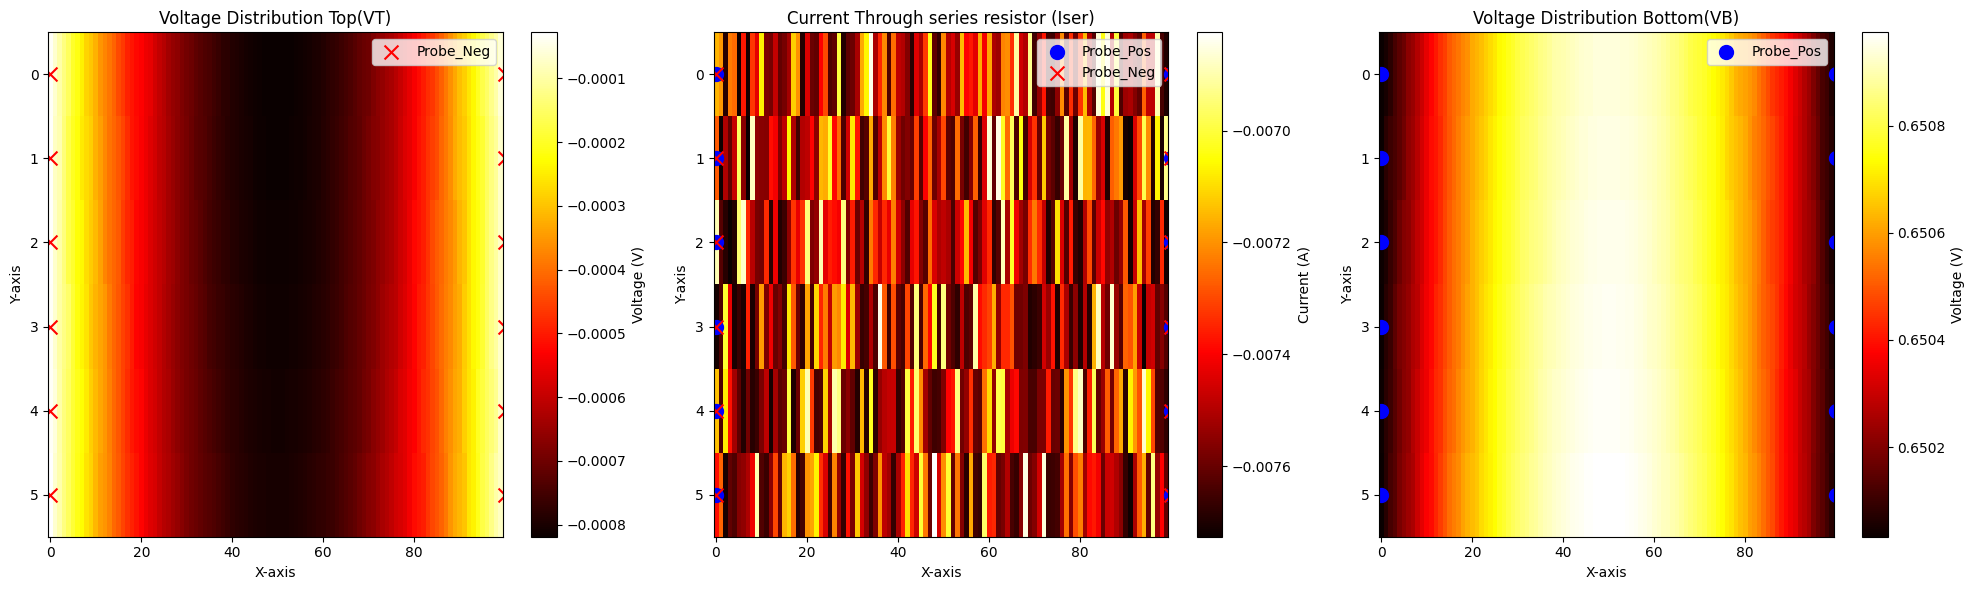

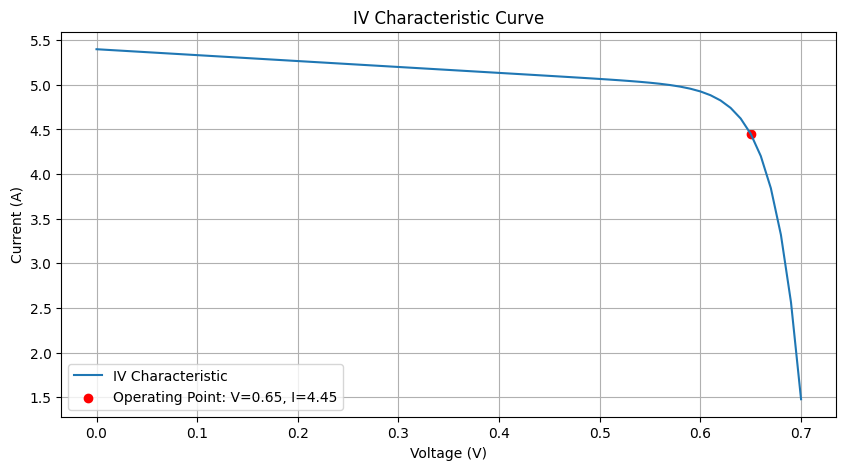

In [12]:
# Extract x, y positions for probes
Probe_pos_x, Probe_pos_y = zip(*Probe_pos)
Probe_neg_x, Probe_neg_y = zip(*Probe_neg)

# Choose the slice index to visualize
slice_index = 65

# Calculate operating point (example: using the mean values at the slice index)
V_op = np.mean(V[slice_index])
I_op = np.mean(I[slice_index])


# Display the images
print(np.shape(I_grid))
plt.figure(figsize=[20, 6])

# Forward Voltage (VF) plane
plt.subplot(1, 3, 1)
plt.scatter(Probe_neg_y, Probe_neg_x, color='red', label='Probe_Neg', s=100, marker='x')  # Negative probesplt.legend()
plt.imshow(VF_grid[:, :, slice_index], aspect='auto', cmap='hot')
plt.colorbar(label='Voltage (V)')
plt.title('Voltage Distribution Top(VT)')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend()

# Current (I) plane
plt.subplot(1, 3, 2)
plt.scatter(Probe_pos_y, Probe_pos_x, color='blue', label='Probe_Pos', s=100, marker='o')  # Positive probes
plt.scatter(Probe_neg_y, Probe_neg_x, color='red', label='Probe_Neg', s=100, marker='x')  # Negative probes
plt.imshow(I_grid[:, :, slice_index], aspect='auto', cmap='hot')
plt.colorbar(label='Current (A)')
plt.title('Current Through series resistor (Iser)')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend()

# Back Voltage (VB) plane
plt.subplot(1, 3, 3)
plt.scatter(Probe_pos_y, Probe_pos_x, color='blue', label='Probe_Pos', s=100, marker='o')  # Positive probes
plt.imshow(VB_grid[:, :, slice_index], aspect='auto', cmap='hot')
plt.colorbar(label='Voltage (V)')
plt.title('Voltage Distribution Bottom(VB)')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend()
plt.savefig("fin_sim_fr.pdf")
plt.tight_layout()
plt.show()

# Plot IV characteristic curve
plt.figure(figsize=[10, 5])
plt.plot(V_trimmed,I_trimmed, label='IV Characteristic')
plt.scatter(V_op, I_op, color='red', label=f'Operating Point: V={V_op:.2f}, I={I_op:.2f}')
plt.xlabel('Voltage (V)')
plt.ylabel('Current (A)')
plt.title('IV Characteristic Curve')
plt.legend()
plt.grid(True)
plt.savefig("fin_sim_IV.pdf")
plt.show()

In [11]:
# # Define color scale range for the selected plot (VF)
# vmin_vf, vmax_vf = VF_grid.min(), VF_grid.max()  # Range for VF

# # Initialize the figure
# fig, ax = plt.subplots(figsize=(8, 6))

# # Add scatter points for probes
# ax.scatter(Probe_pos_y, Probe_pos_x, color='blue', label='Probe_Pos', s=100, marker='o')
# ax.scatter(Probe_neg_y, Probe_neg_x, color='red', label='Probe_Neg', s=100, marker='x')

# # Initialize the plot with the first frame
# im = ax.imshow(VF_grid[:, :, 0], aspect="auto", cmap="hot", vmin=vmin_vf, vmax=vmax_vf)
# fig.colorbar(im, ax=ax, label="Voltage (V)")

# # Set plot title and labels
# ax.set_title("Voltage Distribution Top (VF)")
# ax.set_xlabel("X-axis")
# ax.set_ylabel("Y-axis")
# ax.legend()

# plt.tight_layout()

# # Animation update function
# def update(slice_index):
#     im.set_array(VF_grid[:, :, slice_index])  # Update VF grid for the current slice index
#     return [im]

# # Create the animation
# anim = FuncAnimation(fig, update, frames=range(1, 76), interval=200, blit=True)

# # Save the animation as a GIF
# gif_writer = PillowWriter(fps=5)  # Adjust FPS for speed
# anim.save("voltage_distribution_top.gif", writer=gif_writer)

# print("GIF saved as 'voltage_distribution_top.gif'")
